# Lab 2: Cats vs Dogs

**Deadline**: Oct 8, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1iHfRjBVuD7rdN1WNhs5ceiXvOhvQqvcf/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)

    norm_labels = (labels - min_val)//(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

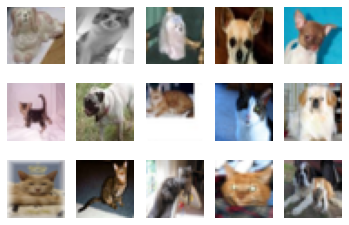

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
# ANSWER:

print("Training examples =", len(train_loader))
print("Validation examples =", len(val_loader))
print("Test examples =", len(test_loader))

Training examples = 8000
Validation examples = 2000
Test examples = 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

**ANSWER:**

We require a validation set to tune the hyperparameters of the model. If we judge the performance using the training set loss/error, we run the risk of overfitting our model to the training set data resulting in poor generalization. This will ultimately lead to poor performance in the real world (test set).

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
# ANSWER:

# Determine the number of elements in each tensor and sum to get the total
# number of parameters in small_net

total_small_net = 0
for param in small_net.parameters():
    total_small_net += param.numel()
    
print("Total number of parameters in small_net:", total_small_net)

Total number of parameters in small_net: 386


In [ ]:
# ANSWER:

# Determine the number of elements in each tensor and sum to get the total
# number of parameters in large_net

total_large_net = 0
for param in large_net.parameters():
    total_large_net += param.numel()

print("Total number of parameters in large_net:", total_large_net)

Total number of parameters in large_net: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# ANSWER:

print("batch_size = 64")
print("learning_rate = 0.01")
print("num_epochs = 30")

batch_size = 64
learning_rate = 0.01
num_epochs = 30


### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

**ANSWER:**

The following files are written to disk when the code block above is ran:

*  model_small_bs64_lr0.01_epoch4_train_err.csv
*  model_small_bs64_lr0.01_epoch4_train_loss.csv
*  model_small_bs64_lr0.01_epoch4_val_err.csv
*  model_small_bs64_lr0.01_epoch4_val_loss.csv

Each file contains a single column of values, where each value is the average  classification error or average loss function achieved on the training/validation sets. For instance, the first file listed contains the average classification error recorded on the training data set. The second file listed contains the average loss function recorded on the training data set. Similarly, the third and fourth files contain the same information but for the validation data set.


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/APS360/Labs/Lab2


/content/gdrive/My Drive/Colab Notebooks/APS360/Labs/Lab2


In [ ]:
# ANSWER:

# Train small_net with default parameters (bs = 64, lr = 0.01, epochs = 30)
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43925, Train loss: 0.6837761926651001 |Validation err: 0.3915, Validation loss: 0.6662304643541574
Epoch 2: Train err: 0.381, Train loss: 0.6527671046257019 |Validation err: 0.3935, Validation loss: 0.6627484038472176
Epoch 3: Train err: 0.342125, Train loss: 0.6254118785858155 |Validation err: 0.3355, Validation loss: 0.6185421068221331
Epoch 4: Train err: 0.32375, Train loss: 0.6055736453533173 |Validation err: 0.3385, Validation loss: 0.6168807446956635
Epoch 5: Train err: 0.314625, Train loss: 0.5930185651779175 |Validation err: 0.3195, Validation loss: 0.609646113589406
Epoch 6: Train err: 0.300625, Train loss: 0.581072371006012 |Validation err: 0.3265, Validation loss: 0.604735940694809
Epoch 7: Train err: 0.29825, Train loss: 0.5771709768772125 |Validation err: 0.33, Validation loss: 0.600321295671165
Epoch 8: Train err: 0.294625, Train loss: 0.5692507929801941 |Validation err: 0.30

In [ ]:
# ANSWER:

# Train large_net with default parameters (bs = 64, lr = 0.01, epochs = 30)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.455875, Train loss: 0.689800537109375 |Validation err: 0.42, Validation loss: 0.6789226718246937
Epoch 2: Train err: 0.420375, Train loss: 0.6776725625991822 |Validation err: 0.4335, Validation loss: 0.6791075877845287
Epoch 3: Train err: 0.400875, Train loss: 0.6655828981399536 |Validation err: 0.383, Validation loss: 0.6488888803869486
Epoch 4: Train err: 0.369375, Train loss: 0.647006417274475 |Validation err: 0.3595, Validation loss: 0.6388816200196743
Epoch 5: Train err: 0.355875, Train loss: 0.6303391318321228 |Validation err: 0.3515, Validation loss: 0.6246991939842701
Epoch 6: Train err: 0.335625, Train loss: 0.6161559634208679 |Validation err: 0.335, Validation loss: 0.6143006030470133
Epoch 7: Train err: 0.328, Train loss: 0.6023777804374695 |Validation err: 0.344, Validation loss: 0.6083009485155344
Epoch 8: Train err: 0.308625, Train loss: 0.5866454269886017 |Validation err: 0.

**ANSWER:**

`small_net` took 102.35 seconds and `large_net` took 117.68 seconds to train. Although the exact numbers vary between each run, and cloud infrastructure/resource allocation contributes slightly to the differences in total elapsed times for each network, the general trend shows that `large_net` takes longer to train. This is expected since `large_net` has so many more parameters that need to be learned i.e. 9705 versus 386 for `small_net`.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

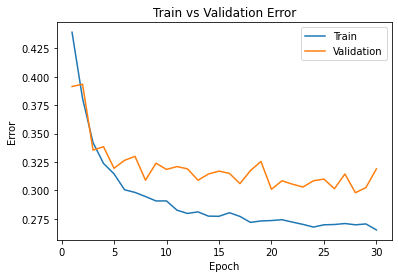

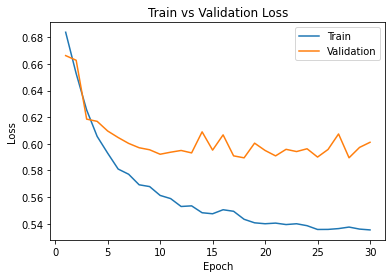

In [ ]:
#ANSWER:

# Plot the trajectory for the small_net
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_model_path)

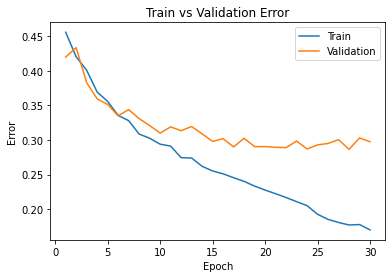

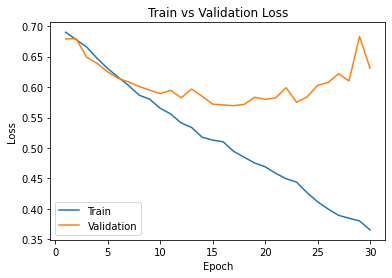

In [ ]:
# ANSWER:

# Plot the trajectory for the large_net
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**ANSWER:**

The curve for training error on both networks show training error decreasing with the number of epochs. For `small_net`, this decrease seems to be happening exponentially, whereas for `large_net`, the decay is much slower (almost linear after a point). The highest and lowest training errors seen are also very similar for both networks. We see similar trends for the training loss on both networks.

Underfitting occurs in both cases until epoch 5 approximately. During this time, we see both training and validation errors to be quite high. After epoch 5, we see the training and validation error curves separate for both networks. This implies that the network is getting better at classifying images in the training data set than the validation data set, signalling poor generalization skills. This is an occurence of overfitting to the training data set.


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

# ANSWER:

# Train large_net with default batch size and number of epochs, but a decreased
# learning rate
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6955151124000549 |Validation err: 0.509, Validation loss: 0.6958169657737017
Epoch 2: Train err: 0.49775, Train loss: 0.6941926455497742 |Validation err: 0.509, Validation loss: 0.694497661665082
Epoch 3: Train err: 0.49775, Train loss: 0.6935119180679321 |Validation err: 0.509, Validation loss: 0.6939931698143482
Epoch 4: Train err: 0.49775, Train loss: 0.6931246314048767 |Validation err: 0.509, Validation loss: 0.6936436221003532
Epoch 5: Train err: 0.49775, Train loss: 0.6928350024223328 |Validation err: 0.509, Validation loss: 0.6931494008749723
Epoch 6: Train err: 0.49775, Train loss: 0.6925871567726135 |Validation err: 0.509, Validation loss: 0.6927506569772959
Epoch 7: Train err: 0.497, Train loss: 0.6923476557731628 |Validation err: 0.507, Validation loss: 0.6925271786749363
Epoch 8: Train err: 0.4795, Train loss: 0.6920522694587707 |Validation err: 0.501, Vali

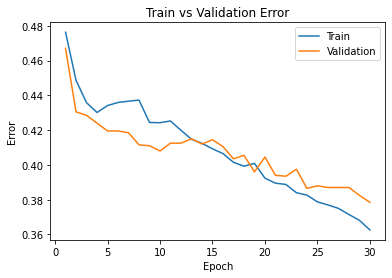

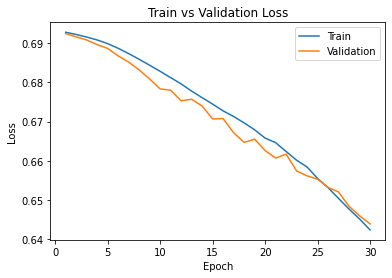

In [ ]:
# ANSWER:

# Plot of the training curve for the new model
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

**ANSWER:**

`large_net` now takes 118.67 seconds to train, which is approximately the same as the 117.68 seconds required when `learning_rate = 0.01` (0.8% increase). It is interesting to note that although the decreased learning rate implies that the step sizes are now smaller, the model does not need more time to find a set of weights that minimize the loss.

From the plots above, we see that the the validation error/loss curves follow the training error/loss curves more closely after decreasing the learning rate as opposed to the scenario seen in part 2(e) where the curves begin to diverge after epoch 5. However, the actual training and validation errors/loss values are much higher with the decreased learning rate, implying that the lower learning rate is not allowing the model to train adequately or as well as it could with `learning_rate = 0.01`.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
# ANSWER

# Start the training with random weights and not the previously obtained values
large_net = LargeNet()

# Train large_net with default batch size and number of epochs but an increased
# learning rate
train_net(large_net, learning_rate=0.1)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6742977547645569 |Validation err: 0.3765, Validation loss: 0.6370316985994577
Epoch 2: Train err: 0.369625, Train loss: 0.6419942178726197 |Validation err: 0.375, Validation loss: 0.6421687360852957
Epoch 3: Train err: 0.36025, Train loss: 0.6315926456451416 |Validation err: 0.338, Validation loss: 0.6223371177911758
Epoch 4: Train err: 0.334125, Train loss: 0.6084355125427247 |Validation err: 0.333, Validation loss: 0.6210155226290226
Epoch 5: Train err: 0.327, Train loss: 0.5968132178783416 |Validation err: 0.316, Validation loss: 0.593926228582859
Epoch 6: Train err: 0.3065, Train loss: 0.5736211636066437 |Validation err: 0.308, Validation loss: 0.5758339520543814
Epoch 7: Train err: 0.286625, Train loss: 0.557759182214737 |Validation err: 0.3255, Validation loss: 0.5994757367298007
Epoch 8: Train err: 0.287625, Train loss: 0.5451903882026672 |Validation err: 0.3075,

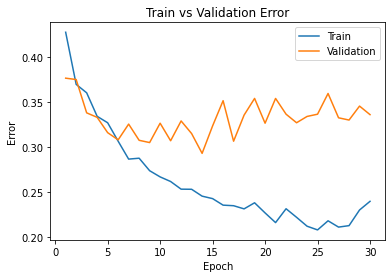

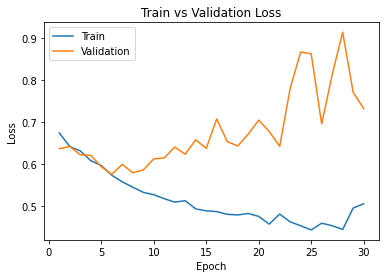

In [ ]:
# ANSWER:

# Plot of the training curve for the new model
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

**ANSWER:**

`large_net` now takes 120.26 seconds to train, which is approximately the same as the 117.68 seconds required when `learning_rate = 0.01` (2.2% increase).

From the plots above, we see that the the validation error/loss curves diverge again from the training error/loss curves after epoch 5 similar to part 2(e). The actual training and validation error values are also much higher with the increased learning rate, implying that the increased learning rate (and bigger step sizes) did not allowing the model to converge to a set of weights that minimized the loss. In fact, on the second plot, we can see the training/validation losses increase with the number of epochs after epoch 15, which means that the gradient is increasing, providing more feedback to the model and indicating that the weights are required to be changed. The model is less confident in its predictions.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
# ANSWER

# Start the training with random weights and not the previously obtained values
large_net = LargeNet()

# Train large_net with default learning rate and number of epochs but an increased
# batch size
train_net(large_net, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379440844059 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103945493698 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500553488731 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449865877628 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935664117336 |Validation err: 0.424, Validation loss: 0.6881355196237564
Epoch 6: Train err: 0.438, Train loss: 0.6883532032370567 |Validation err: 0.4285, Validation loss: 0.6860118806362152
Epoch 7: Train err: 0.439375, Train loss: 0.6866871640086174 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, 

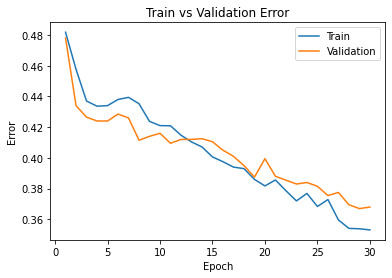

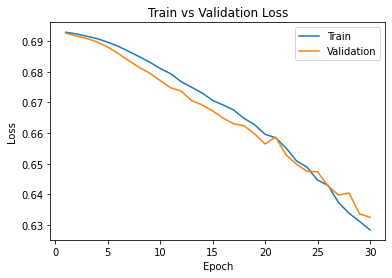

In [ ]:
# ANSWER:

# Plot of the training curve for the new model
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

**ANSWER:**

`large_net` now takes 106.41 seconds to train, which is much shorter than the 117.68 seconds required when `batch_size = 64` (9.6% decrease). I believe this is expected behavior as the number of batches that make up an epoch and consequently, the number of times the loss is calculated and optimized, has decreased.

From the plots above, we see that the the validation error/loss curves follow the training error/loss curves more closely after increasing the learning rate as opposed to the scenario seen in part 2(e) where the curves begin to diverge after epoch 5. This implies that the model is getting better at generalizing. We also see a steady decline in the average training/validation loss. However, the actual training and validation errors/loss values are still much higher with the increased batch size.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
# ANSWER

# Start the training with random weights and not the previously obtained values
large_net = LargeNet()

# Train large_net with default learning rate and number of epochs but an decreased
# batch size
train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775410465598106 |Validation err: 0.3785, Validation loss: 0.651269543170929
Epoch 2: Train err: 0.367875, Train loss: 0.6389183864593506 |Validation err: 0.3495, Validation loss: 0.6170854353904724
Epoch 3: Train err: 0.340375, Train loss: 0.6114947981238366 |Validation err: 0.343, Validation loss: 0.6361264021396636
Epoch 4: Train err: 0.31175, Train loss: 0.5834803532958031 |Validation err: 0.3415, Validation loss: 0.6126863491535187
Epoch 5: Train err: 0.301125, Train loss: 0.5638278910517692 |Validation err: 0.311, Validation loss: 0.5762235834598541
Epoch 6: Train err: 0.28475, Train loss: 0.5464649626612663 |Validation err: 0.3045, Validation loss: 0.5770110754966736
Epoch 7: Train err: 0.270625, Train loss: 0.5266695675551891 |Validation err: 0.2965, Validation loss: 0.5703191385269165
Epoch 8: Train err: 0.254, Train loss: 0.5092709631323814 |Validation err: 

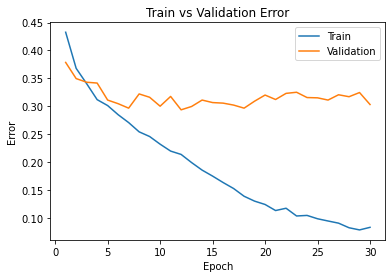

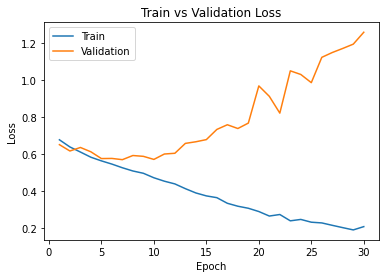

In [ ]:
# ANSWER:

# Plot of the training curve for the new model
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

**ANSWER:**

`large_net` now takes 168.23 seconds to train, which is much longer than the 117.68 seconds required when batch_size = 64. I believe this is expected behavior. A smaller batch size implies that there are more batches per epoch. As a result, the number of times that loss is calculated and optimized also increases.

From the plots above, we see that the the validation error/loss curves begin to diverge from the training error/loss curves after epoch 5 similar to the scenario seen in part 2(e) with `batch_size = 64`. The training/validation error values are lower/around the same as part 2(e). On the second plot, we see the validation loss curve increasing steadily after epoch 10. Since the loss is a calculation of how "off" a model's predicted label is from the true label, an increasing loss function would imply that the model is becoming increasingly less confident in its predictions.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**ANSWER:**

I am using the validation error/loss curves generated in parts 2 and 3 to justify hyperparameter choices. This is because the network's performance on the validation data set is a good indication to how well the model is generalizing, which is the ultimate goal for a neural network.

* Network: `large_net`. From part 2(e), we see that the validation error curve from `large_net` is much more stable than the one from `small_net`. The validation loss curves are similar for both cases - since they seem to even out with the number of epochs, we know that the gradient and feedback into model is decreasing resulting in minimal changes to the weights.


* Learning Rate: 0.001. I picked this learning rate through a process of elimination. From part 3(b), with `learning_rate = 0.1`, we see that the validation loss curve is rising with the number of epochs. Combined with the slight increase in validation error between epochs 10 and 30, it can concluded that the model has yet to find a set of weights that minimizes the loss function and this learning rate is too large. 

* Batch Size: 1024. As seen in part 3(d), using `batch_size = 16` resulted in a model that was becoming less confident in its predictions. On the other hand, using `batch_size = 512` resulted in a model that was becoming more confident but not quickly enough as seen in part 3(c). As a result, I picked a number much greater than 512 i.e. `batch_size = 1024`.


### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
# ANSWER

# Start the training with random weights and not the previously obtained values
large_net = LargeNet()

# Train large_net with the specified hyperparameters
train_net(large_net, batch_size=1024, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6958246901631355 |Validation err: 0.491, Validation loss: 0.6947904527187347
Epoch 2: Train err: 0.50225, Train loss: 0.695862852036953 |Validation err: 0.491, Validation loss: 0.6947174668312073
Epoch 3: Train err: 0.50225, Train loss: 0.6956272572278976 |Validation err: 0.491, Validation loss: 0.694572776556015
Epoch 4: Train err: 0.50225, Train loss: 0.6954425051808357 |Validation err: 0.491, Validation loss: 0.6944084465503693
Epoch 5: Train err: 0.50225, Train loss: 0.6952316090464592 |Validation err: 0.491, Validation loss: 0.6943638622760773
Epoch 6: Train err: 0.50225, Train loss: 0.6951145157217979 |Validation err: 0.491, Validation loss: 0.694235235452652
Epoch 7: Train err: 0.50225, Train loss: 0.694974921643734 |Validation err: 0.491, Validation loss: 0.6941598057746887
Epoch 8: Train err: 0.50225, Train loss: 0.6948093101382256 |Validation err: 0.491, Vali

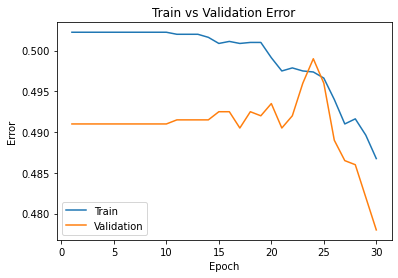

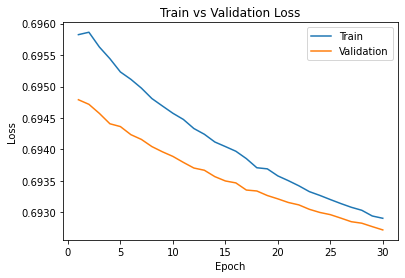

In [ ]:
# ANSWER:

# Plot of the training curve for the new model
large_model_path = get_model_name("large", batch_size=1024, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

**ANSWER:**

Again, similar to part 4(a), I am using the validation error/loss curves generated in part 4(b) to justify my choice of hyperparameters. 

* Network: `large_net` and Learning Rate: 0.001. These have been picked seeing that they result in decreasing validation error in part 4(c) - see first plot above.

* Batch size: 32. The validation error/loss decreasing slowly (see second plot in part 4(c)) implies that increasing the number of epochs could increase the model performance. However, I was unable to increase the number of epochs to more than 30 (ending up with an unfixable "divide by zero" error). Hence, I will be using a much smaller batch size to somewhere between 16 and 64 (default value). This is because a lower validation error was observed with `batch_size = 16` in part 3(d).

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
# ANSWER

# Start the training with random weights and not the previously obtained values
large_net = LargeNet()

# Train large_net with the specified hyperparameters from part (d)
train_net(large_net, batch_size=32, learning_rate=0.001, num_epochs = 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466125, Train loss: 0.6925730059146881 |Validation err: 0.4335, Validation loss: 0.6916963751353915
Epoch 2: Train err: 0.447, Train loss: 0.6912713143825531 |Validation err: 0.4235, Validation loss: 0.6898154729888553
Epoch 3: Train err: 0.43475, Train loss: 0.6893711981773376 |Validation err: 0.418, Validation loss: 0.686753341129848
Epoch 4: Train err: 0.433, Train loss: 0.6866874308586121 |Validation err: 0.42, Validation loss: 0.6824120131749956
Epoch 5: Train err: 0.425875, Train loss: 0.6837986145019531 |Validation err: 0.413, Validation loss: 0.6795235011312697
Epoch 6: Train err: 0.418625, Train loss: 0.6804884846210479 |Validation err: 0.4115, Validation loss: 0.6759858566617208
Epoch 7: Train err: 0.412125, Train loss: 0.6771825730800629 |Validation err: 0.4145, Validation loss: 0.6729660497771369
Epoch 8: Train err: 0.40925, Train loss: 0.6737074253559112 |Validation err: 0.409

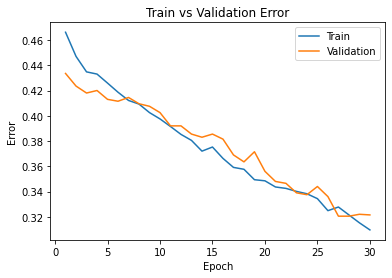

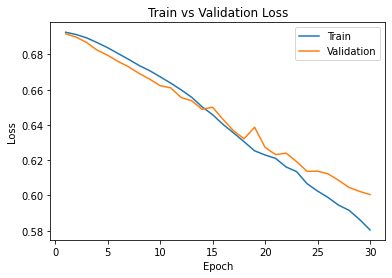

In [ ]:
# ANSWER:

# Plot of the training curve for the new model
large_model_path = get_model_name("large", batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=16, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**ANSWER:**

* Network: `large_net`. The same reasoning as in part 4(a).

* Learning Rate: 0.001. The same reasoning as in part 4(a).

* Batch Size: 16. Among the four batch sizes that were tried (16, 32, 512 and 1024), `batch_size = 16` resulted in the lowest validation error despite a decrease in the confidence of its predictions.

* Number of Epochs: 30. I was not able to increase this value without encountering a "divide by zero" error.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

# ANSWER:

# Define the loss function (Binary Cross Entropy)
criterion = nn.BCEWithLogitsLoss()

# Calculate the test classification error and loss function
test_err, test_loss = evaluate(net, test_loader, criterion)

# Report the test classification error
print("CNN Test Error:", test_err)
print("CNN Test Loss:", test_loss)

Files already downloaded and verified
Files already downloaded and verified
CNN Test Error: 0.2885
CNN Test Loss: 0.5594693096354604


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# ANSWER:

# Calculate the validation classification error and loss function
val_err, val_loss = evaluate(net, val_loader, criterion)

# Report the validation classification error
print("CNN Validation Error:", val_err)
print("CNN Validation Loss:", val_loss)

CNN Validation Error: 0.309
CNN Validation Loss: 0.5825843689963222


**ANSWER:**

As seen in part 5(c) and the code block above, the test error is much lower than the validation error (0.2885 for test versus 0.309 for validation).

This is unexpected for the following reason: the model has been trained using the validation data set i.e. hyperparameter tuning,  whereas it is only seeing the test data set for the first time. As a result, it only stands to reason that the model would be able to classify images that it has already seen before much better than brand new ones.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**ANSWER:**

We do not use the test data until the very end because we want to avoid tuning our model parameters and hyperparameters according to a specific test data set. Using the test data as a "final" verification of the model performance gives us more accurate representations of what we can expect from our model in "real-world situations", or data sets that it has never seen before.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
# ANSWER:

# List of modifiable hyperparameters tuned using validation error/loss
num_hidden_units = 100
activation_function = F.relu
ann_batch_size = 128
ann_learning_rate = 0.001
ann_num_epochs = 32

# Define a 2-layer artificial neural network
class two_layer_ANN(nn.Module):
    def __init__(self):
        super(two_layer_ANN, self).__init__()
        self.name = "ann"
        self.layer1 = nn.Linear(3 * 32 * 32, num_hidden_units)
        self.layer2 = nn.Linear(num_hidden_units, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = activation_function(activation1)
        activation2 = self.layer2(activation1).squeeze(1)
        return activation2

# Train the 2-layer ANN using parameters defined above
ANN_net = two_layer_ANN()
train_net(ANN_net, batch_size=ann_batch_size, learning_rate=ann_learning_rate, num_epochs=ann_num_epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43975, Train loss: 0.6839624908235338 |Validation err: 0.41, Validation loss: 0.6749030165374279
Epoch 2: Train err: 0.4015, Train loss: 0.6682770507676261 |Validation err: 0.406, Validation loss: 0.6663249172270298
Epoch 3: Train err: 0.397375, Train loss: 0.6609164627771529 |Validation err: 0.4005, Validation loss: 0.6628468334674835
Epoch 4: Train err: 0.38775, Train loss: 0.6554602441333589 |Validation err: 0.395, Validation loss: 0.6582896187901497
Epoch 5: Train err: 0.37975, Train loss: 0.6509704864214337 |Validation err: 0.3925, Validation loss: 0.6560682244598866
Epoch 6: Train err: 0.377875, Train loss: 0.6476211812761095 |Validation err: 0.39, Validation loss: 0.6544539779424667
Epoch 7: Train err: 0.37225, Train loss: 0.6443026425346495 |Validation err: 0.388, Validation loss: 0.652288418263197
Epoch 8: Train err: 0.36775, Train loss: 0.6412662163613334 |Validation err: 0.3825,

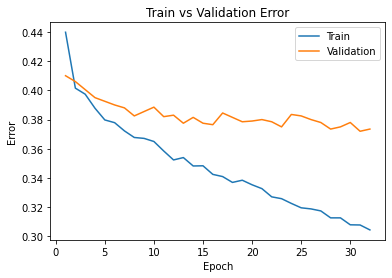

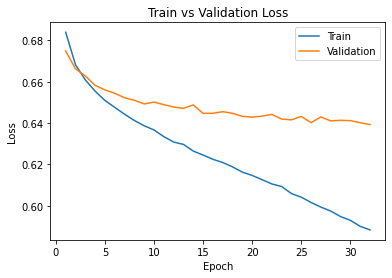

In [ ]:
# ANSWER:

# Plot of the training curve for the ANN
# This is used to tune the hyperparameters of the model

ann_model_path = get_model_name("ann", batch_size=128, learning_rate=0.001, epoch=31)
plot_training_curve(ann_model_path)

In [ ]:
# ANSWER:

# Load the chosen set of weights into the object 'model'
net = two_layer_ANN()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.001, epoch=31)
state = torch.load(model_path)
net.load_state_dict(state)

# Load the data sets
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)

# Define the loss function (Binary Cross Entropy)
criterion = nn.BCEWithLogitsLoss()

# Calculate the test classification error and loss function for the ANN
ann_test_err, ann_test_loss = evaluate(net, test_loader, criterion)

# Report the test classification error
print("ANN Test Error:", ann_test_err)
print("ANN Test Loss:", ann_test_loss)

Files already downloaded and verified
Files already downloaded and verified
ANN Test Error: 0.3545
ANN Test Loss: 0.6307429168373346


**ANSWER:**

As seen in the code block above for the ANN's and in part 5(c) for the CNN's performances, the CNN is a much better model at binary classification of the images. From the test data set, we see that the CNN achieves a classification error of approximately 0.3 whereas the ANN barely dips below 0.38. Moreover, we see that the CNN is more confident in its predictions (average loss of 0.58) compared to the ANN (average loss of 0.63).